In [ ]:
import os
import pandas as pd
import numpy as np
import spacy
import unidecode
import contractions as contract
import re
import wordninja
import collections
import pkg_resources
from spellchecker import SpellChecker
from symspellpy import SymSpell, Verbosity

In [ ]:
pip install -qqq unidecode contractions pyspellchecker wordninja symspellpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 58.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 541.6/541.6 kB 34.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 71.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 kB 9.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 11.1 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Tumblr Vietnam/Tusat.csv', index_col=0)
df.reset_index(drop=True, inplace=True)
df.head()

,text,class
0,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,Am I weird I don't get affected by compliments...,non-suicide
2,Finally 2020 is almost over... So I can never ...,non-suicide
3,i need helpjust help me im crying so hard,suicide
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


<ipython-input-8-2a9e9960ed33>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=df['class'], palette=mypal[1::4])


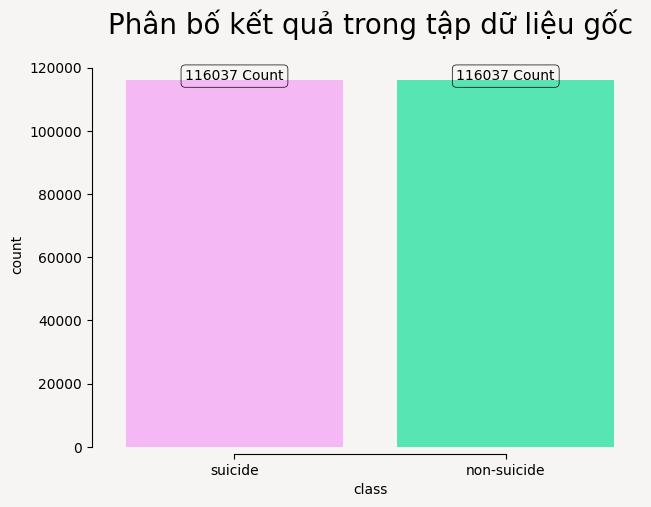

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

mypal= ['#FC05FB', '#FEAEFE', '#FCD2FC','#F3FEFA', '#B4FFE4','#3FFEBA']

plt.figure(figsize=(7, 5), facecolor='#F6F5F4')
total = float(len(df))
ax = sns.countplot(x=df['class'], palette=mypal[1::4])
ax.set_facecolor('#F6F5F4')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 3, '{:1.0f} Count'.format(height), ha="center",
           bbox=dict(facecolor='none', edgecolor='black', boxstyle='round', linewidth=0.5))

ax.set_title('Phân bố kết quả trong tập dữ liệu gốc', fontsize=20, y=1.05)
sns.despine(right=True)
sns.despine(offset=5, trim=True)

plt.show()


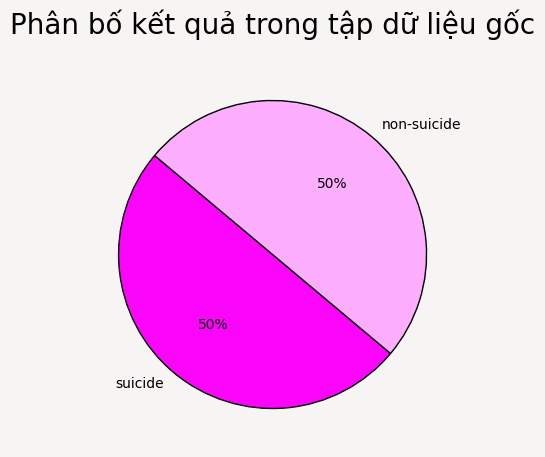

In [ ]:
import matplotlib.pyplot as plt

# Dữ liệu phân loại
data = df['class'].value_counts()

# Màu sắc tùy chỉnh
mypal= ['#FC05FB', '#FEAEFE', '#FCD2FC','#F3FEFA', '#B4FFE4','#3FFEBA']

# Vẽ biểu đồ tròn
plt.figure(figsize=(7, 5), facecolor='#F6F5F4')
plt.pie(data, labels=data.index, colors=mypal, autopct='%1.0f%%', startangle=140, wedgeprops={'edgecolor': 'black'})

# Tiêu đề biểu đồ
plt.title('Phân bố kết quả trong tập dữ liệu gốc', fontsize=20, y=1.05)

# Hiển thị biểu đồ
plt.show()


In [ ]:
len(df)

232074

In [ ]:
# Defining methods

nlp = spacy.load("en_core_web_sm")
vocab = collections.Counter()
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt")
bigram_path = pkg_resources.resource_filename(
"symspellpy", "frequency_bigramdictionary_en_243_342.txt")
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
sym_spell.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)

# Spell Check using Symspell
def fix_spelling(text):
    suggestions = sym_spell.lookup_compound(text, max_edit_distance=2)
    correctedtext = suggestions[0].term # get the first suggestion, otherwise returns original text if nothing is corrected
    return correctedtext

# Remove some important words from stopwords list
deselect_stop_words = ['no', 'not']

for w in deselect_stop_words:
    nlp.vocab[w].is_stop = False

# Remove extra whitespaces from text
def remove_whitespace(text):
    text = text.strip()
    return " ".join(text.split())

# Remove accented characters from text, e.g. café
def remove_accented_chars(text):
    text = unidecode.unidecode(text)
    return text

# Remove URL
def remove_url(text):
    return re.sub(r'http\S+', '', text)

# Removing symbols and digits
def remove_symbols_digits(text):
    return re.sub('[^a-zA-Z\s]', ' ', text)

# Removing special characters
def remove_special(text):
    return text.replace("\r", " ").replace("\n", " ").replace("    ", " ").replace('"', '')

# Fix word lengthening (characters are wrongly repeated)
def fix_lengthening(text):
    pattern = re.compile(r"(.)\1{2,}")
    return pattern.sub(r"\1\1", text)

def text_preprocessing(text, accented_chars=True, contractions=True, convert_num=True,
                       extra_whitespace=True, lemmatization=True, lowercase=True,
                       url=True, symbols_digits=True, special_chars=True,
                       stop_words=True, lengthening=True, spelling=True):
    """preprocess text with default option set to true for all steps"""
    if accented_chars == True: # remove accented characters
        text = remove_accented_chars(text)
    if contractions == True: # expand contractions
        text = contract.fix(text)
    if lowercase == True: # convert all characters to lowercase
        text = text.lower()
    if url == True: # remove URLs before removing symbols
        text = remove_url(text)
    if symbols_digits == True: # remove symbols and digits
        text = remove_symbols_digits(text)
    if special_chars == True: # remove special characters
        text = remove_special(text)
    if extra_whitespace == True: # remove extra whitespaces
        text = remove_whitespace(text)
    if lengthening == True: # fix word lengthening
        text = fix_lengthening(text)
    if spelling == True: # fix spelling
        text = fix_spelling(text)

    doc = nlp(text) # tokenise text

    clean_text = []

    # return text

    for token in doc:
        flag = True
        edit = token.text
        # remove stop words
        if stop_words == True and token.is_stop and token.pos_ != 'NUM':
            flag = False
        # exclude number words
        if convert_num == True and token.pos_ == 'NUM' and flag == True:
            flag = False
        # convert tokens to base form
        elif lemmatization == True and token.lemma_ != "-PRON-" and flag == True:
            edit = token.lemma_
        # append tokens edited and not removed to list
        if edit != "" and flag == True:
            clean_text.append(edit)
    return " ".join(clean_text)


In [ ]:
df['cleaned_text'] = df['text'][:20].apply(lambda row: text_preprocessing(row))
df[:20]

,text,class,cleaned_text
0,Ex Wife Threatening SuicideRecently I left my ...,suicide,sex wife threaten suicide recently leave wife ...
1,Am I weird I don't get affected by compliments...,non-suicide,weird not affect compliment come know girl fee...
2,Finally 2020 is almost over... So I can never ...,non-suicide,finally hear bad year swear fucking god annoying
3,i need helpjust help me im crying so hard,suicide,need help help cry hard
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide,lose hello adam struggle year afraid past year...
5,Honetly idkI dont know what im even doing here...,suicide,honestly d not know feel like feel unbearably ...
6,[Trigger warning] Excuse for self inflicted bu...,suicide,trigger warn excuse self inflict burn know cri...
7,It ends tonight.I can’t do it anymore. \nI quit.,suicide,end tonight not anymore quit
8,"Everyone wants to be ""edgy"" and it's making me...",non-suicide,want edgy make self conscious feel like not st...
9,My life is over at 20 years oldHello all. I am...,suicide,life year old hello year old bald male hairlin...


In [ ]:
df['cleaned_text'] = df['text'].apply(lambda row: text_preprocessing(row))

In [ ]:
df

,text,class,cleaned_text
0,Ex Wife Threatening SuicideRecently I left my ...,suicide,sex wife threaten suicide recently leave wife ...
1,Am I weird I don't get affected by compliments...,non-suicide,weird not affect compliment come know girl fee...
2,Finally 2020 is almost over... So I can never ...,non-suicide,finally hear bad year swear fucking god annoying
3,i need helpjust help me im crying so hard,suicide,need help help cry hard
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide,lose hello adam struggle year afraid past year...
...,...,...,...
232069,If you don't like rock then your not going to ...,non-suicide,not like rock not go
232070,You how you can tell i have so many friends an...,non-suicide,tell friend not lonely deprive buy little nigh...
232071,pee probably tastes like salty tea😏💦‼️ can som...,non-suicide,pee probably taste like salty tea drink pee co...
232072,The usual stuff you find hereI'm not posting t...,suicide,usual stuff find not post sympathy pity know f...


In [ ]:
df.to_csv('/content/drive/MyDrive/Tumblr Vietnam/Tusat2.csv', index=False)


In [ ]:
df.to_csv('/content/drive/MyDrive/Tumblr Vietnam/123.csv', index=True)

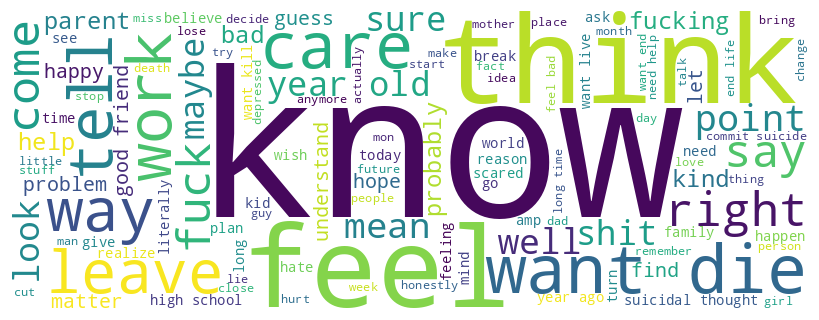

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Lọc các từ trong cột 'cleaned_text' có nhãn là 'suicide'
suicide_text = df[df['class'] == 'suicide']['cleaned_text'].str.cat(sep=' ')

# Tạo WordCloud
wordcloud = WordCloud(width = 800, height = 300,
                background_color ='white',
                stopwords = None,
                min_font_size = 10).generate(suicide_text)

# Hiển thị biểu đồ từ
plt.figure(figsize = (8, 3), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()


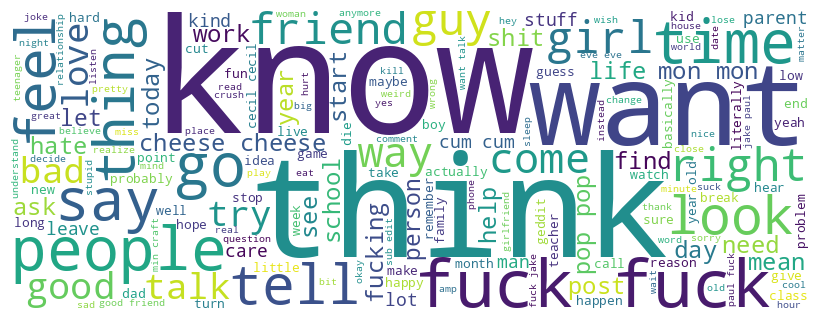

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Lọc các từ trong cột 'cleaned_text' có nhãn là 'suicide'
suicide_text = df[df['class'] == 'non-suicide']['cleaned_text'].str.cat(sep=' ')

# Tạo WordCloud
wordcloud = WordCloud(width = 800, height = 300,
                background_color ='white',
                stopwords = None,
                min_font_size = 10).generate(suicide_text)

# Hiển thị biểu đồ từ
plt.figure(figsize = (8, 3), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()


In [ ]:

import pandas as pd
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['cleaned_text'])
word_freq = pd.DataFrame(tokenizer.word_counts.items(), columns=['word','count']).sort_values(by='count', ascending=False)

In [ ]:

df['cleaned_text'] = df['cleaned_text'].str.replace('filler', '')


In [ ]:
cleaned_df = df[df['cleaned_text'].apply(lambda x: len(x.split())<=62)]
cleaned_df.reset_index(drop=True, inplace=True)

In [ ]:
len(df)

232074